## Qiskit Projects

This document contains several projects in the field of quantum computations. These projects are for educational purposes only, and may even be deemed problems that we try to solve, rather than projects. These are implemented using the pyhon library `qiskit`, which provides a quantum simulator that simulates a quantum circuit and the outcome is ideally what one expects on a real quantum device. Although real quantum devices are noisy and we never really get a perfect answer, there is always some noise.

### Quantum Random Number Generator

Essentially, quantum random number generators utilize the Hadamard gate to create a superposition of qubits. This gate transforms qubits from the 0 state to an equal superposition of the 0 and 1 states. Consequently, when the quantum circuit concludes, there is an equal likelihood of measuring a qubit value of 0 or 1. By treating a sequence of qubits as a binary value, applying the Hadamard gate to each qubit and subsequently performing a measurement, a random bitstring and, consequently, a random number can be generated.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_state_city

In [2]:
def real_map(value, leftMin, leftMax, rightMin, rightMax):
    # Maps one range to another
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)


def QRandNum(lb, ub):
    # Quantum Random Number generator
    # Select the number of qubits 
    qubits = int(np.log2(ub-lb))
    q = QuantumRegister(qubits, 'q')
    circ = QuantumCircuit(q)
    c0 = ClassicalRegister(2, 'c0')
    circ.add_register(c0)

    for i in range(qubits):
        circ.h(q[i])

    for i in range(qubits):
        circ.measure(q[i], c0)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    #print(job.status())
    result = job.result()
    output = np.asarray(result.get_statevector(circ))

    num = 0
    for i in range(len(output)):
        if output[i] != 0:
            num = i
    
    y = real_map(num + 1 , 1, 2**qubits, lb, ub)
    return y

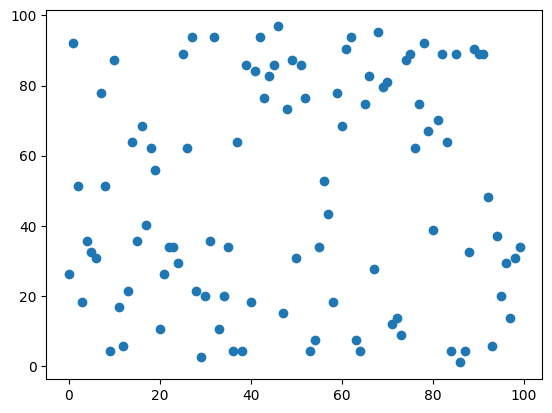

In [3]:
x = []
for i in range(100):
    x.append(QRandNum(1, 100))

plt.scatter(range(0, 100), x)

Quantum number generators are an important tool in the Quantum Key Distribution problem. We hope to come back to it later.

###  Grover’s Search Algorithm

Grover's algorithm has three main components. 
1. First, we begin by creating a superposition of all $2^n$ computational basis states by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 
2. Second, we apply an Oracle operator to mark the appropriate elements among the $2^n$ elements. The oracle operator applies a coefficient of $-1$ to each of the marked elements.
3. Third, we apply a Diffusion operator, or diffuser, which inverts the amplitude of all elements about the average amplitude.

Putting these components together, and applying the Oracle and Diffusion operators $O(\sqrt{N = 2^n})$ times, Grover's algorithm allows us to successfully determine the elements that were marked by the Oracle operator with high probability. This is shown in the block diagram above, where the quantum circuit for Grover's algorithm is depicted with a measurement in the end to read out the qubits.

The goal is to implement Grover's algorithm by creating a quantum circuit that has the marked element `01101`. We will see that the algorithm outputs the marked element with probability greater than $99\%$.

In [4]:
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import plot_histogram

def grover_search(marked_elt: str):
    index = int(marked_elt, 2)

    arr = np.identity(2**(len(marked_elt)))
    arr[index, index] = -1

    unitary_gate = UnitaryGate(arr)

    oracle = QuantumCircuit(5)
    oracle.compose(unitary_gate, qubits=range(5), inplace=True)
    #oracle.draw(output='mpl')

    grover_op = GroverOperator(oracle)

    init = QuantumCircuit(5, 5)
    init.h(range(5))

    qc = init.compose(grover_op)
    qc.compose(grover_op, inplace=True)
    qc.compose(grover_op, inplace=True)
    qc.compose(grover_op, inplace=True)

    qc.measure(range(5),range(5))
    #qc.draw(output='mpl')

    sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, sim)
    counts = sim.run(t_qc).result().get_counts()

    return counts

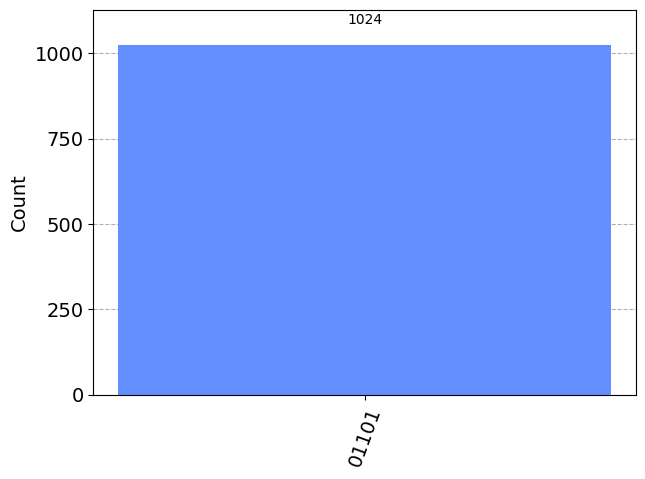

In [5]:
counts = grover_search('01101')
plot_histogram(counts)

The following implementation allows for multiple marked elements, entered as a list of bit strings. The length of the bitstrings must be equal.

In [6]:
def grover_circuit(marked_elts: list):

    n = len(marked_elts[0])
    indices = [int(marked_elt, 2) for marked_elt in marked_elts]
    
    arr = np.identity(2**n)
    for index in indices:
        arr[index, index] = -1
    
    unitary_gate = UnitaryGate(arr)

    oracle = QuantumCircuit(n)
    oracle.compose(unitary_gate, qubits=range(n), inplace=True)
    
    # grover operator
    grover_op = GroverOperator(oracle)

    init = QuantumCircuit(n, n)
    init.h(range(n))

    r = int(np.pi/4*np.sqrt(2**n/len(indices)))
    print(f'{n} qubits, basis states {indices} marked, {r} rounds')

    qc = init.compose(grover_op)
    for _ in range(1, r):
        qc.compose(grover_op, inplace=True)

    qc.measure(range(n),range(n))
    return qc

Let us take two marked elements, `001101` and `101010`.

6 qubits, basis states [13, 42] marked, 4 rounds


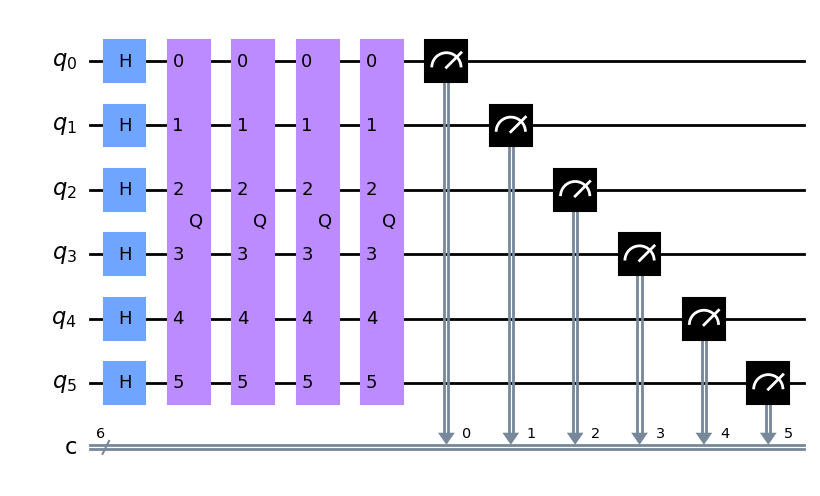

In [7]:
q_circuit = grover_circuit(['001101', '101010'])
q_circuit.draw('mpl')

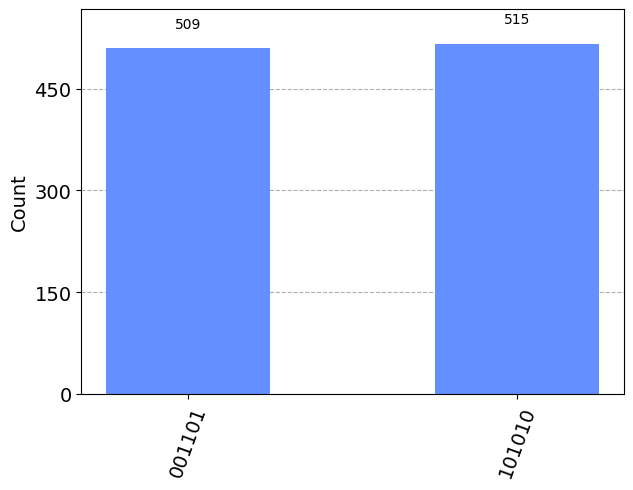

In [8]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(q_circuit, sim)
counts = sim.run(t_qc).result().get_counts()
plot_histogram(counts)

### Deutsch-Jozsa algorithm

The `Deutsch-Jozsa problem` is the following: We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$. The property of the given Boolean function is that it is guaranteed to either be **balanced** or **constant**. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant.

In the classical solution in the worst case one would need to check $2^{n-1} -1$ bits for a function that takes $n$-bit inputs. Using a quantum computer, we can solve this problem with $100 \%$ confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $|x\rangle |y\rangle$ to $|x\rangle |y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$.

In [26]:
# Implementation both with constant and balanced oracles

def build_oracle(size, type='constant'):
    ''' size (int): n for an n-bit the function
        type (str): "constant" or "balanced". default value = constant 
        output: an oracle
    '''
    oracle = QuantumCircuit(size+1)
    if type == 'constant':
        r = np.random.randint(2)
        if r == 1:
            oracle.x(size)
    elif type == 'balanced':
        r = np.random.randint(2**size)
        b_str = (bin(r)[2:]).zfill(size)
        # place X gates determined by b_str
        for qubit in range(size):
            if b_str[qubit] == '1':
                oracle.x(qubit)
        oracle.barrier()
        # controlled not gate
        for qubit in range(size):
            oracle.cx(qubit, size)
        oracle.barrier()
        # place X gates again
        for qubit in range(size):
            if b_str[qubit] == '1':
                oracle.x(qubit)
    else:
        print("Give valid inputs")
        return None
    
    return oracle

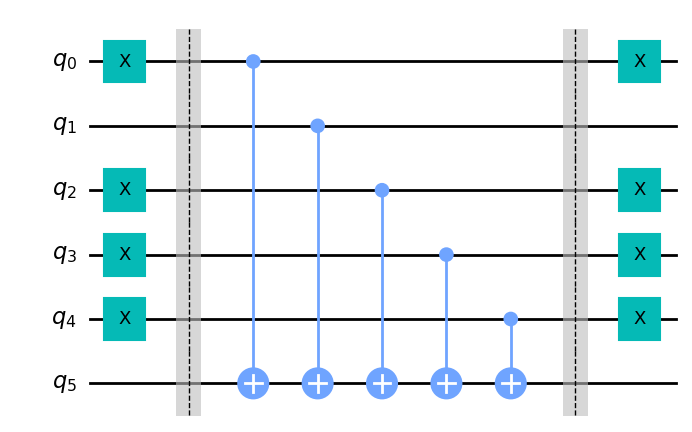

In [30]:
balanced_oracle = build_oracle(5, 'balanced')
balanced_oracle.draw('mpl')

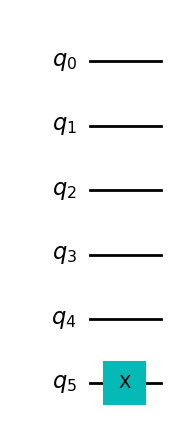

In [29]:
constant_oracle = build_oracle(5)
constant_oracle.draw('mpl')

In [32]:
# Let's built the dj circuit now

def build_dj_circuit(size, oracle):
    ''' size: size of the oracle
        oracle: oracle representing the given function 
    '''
    qc = QuantumCircuit(size+1, size)

    # Apply H gates to the input qubits
    for qubit in range(size):
        qc.h(qubit)
    
    # Initialize the output qubit in the |-> state
    qc.x(size)
    qc.h(size)

    # Add oracle
    qc = qc.compose(oracle)

    # Add the H gate on the input qubits again
    for qubit in range(size):
        qc.h(qubit)
    
    # Measure
    for qubit in range(size):
        qc.measure(qubit, qubit)
    
    return qc

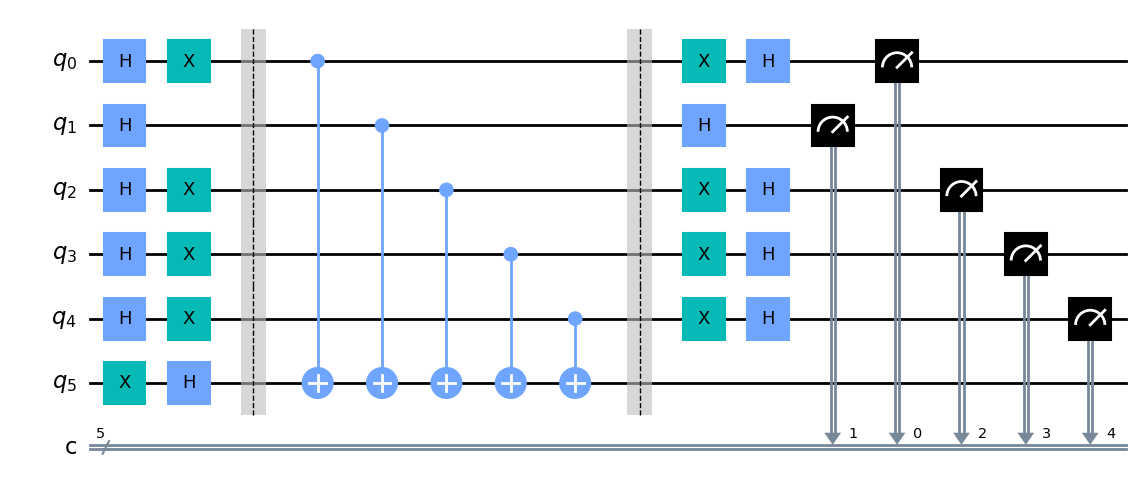

In [33]:
dj_circuit = build_dj_circuit(5, balanced_oracle)
dj_circuit.draw('mpl')

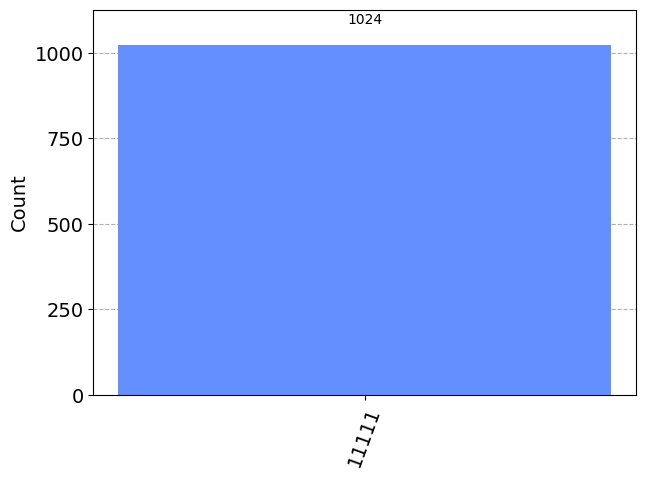

In [34]:
# Output using the Aer simulator
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(dj_circuit, sim)
counts = sim.run(dj_circuit).result().get_counts()

#the output should be anything other than '00000'

plot_histogram(counts)

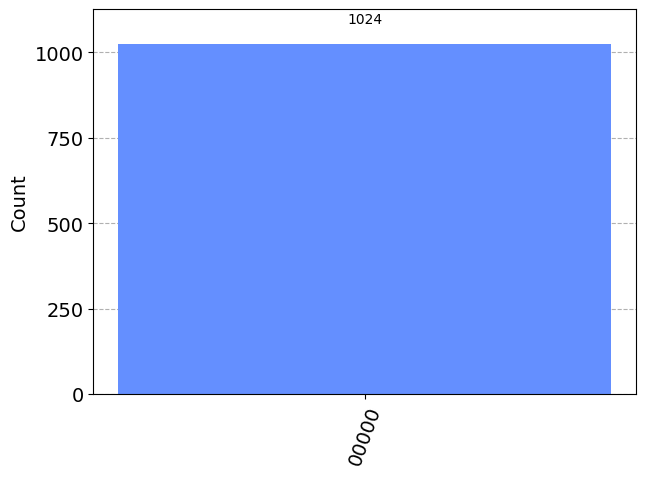

In [35]:
# with the constant oracle the output should always be '00000'
dj_circuit_const = build_dj_circuit(5, constant_oracle)
#dj_circuit_const.draw('mpl')
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(dj_circuit_const, sim)
counts = sim.run(dj_circuit_const).result().get_counts()
plot_histogram(counts)